# Aufgabe 3a: Weinqualität
Für diese Aufgabe wird auf das Datenset Weinqualität zurückgegriffen. Rot- und Weißweine werden wieder in einem Datenset kombiniert. Für die Prädiktion wurde eine Kombination aus Regression und Klassifikation verwendet.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

white = pd.read_csv('winequality-white.csv', sep=';')
red = pd.read_csv('winequality-red.csv', sep=';')

C:\Users\thoma\AppData\Roaming\Python\Python37\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\thoma\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\thoma\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
red['type'] = 1
white['type'] = 0

wines = red.append(white, ignore_index=True)

In [3]:
wines.isna().any().any()

False

## Verteilung
Die Ausprägungen sind sehr ungleich verteilt, einige Qualitätsstufen haben gar keine Beobachtungen.

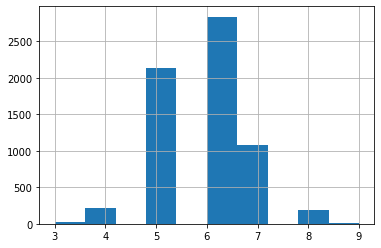

In [4]:
wines.quality.hist()

In [5]:
wines.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

## Korrelation

In [6]:
wines.corr()['quality'].sort_values()

density                -0.305858
volatile acidity       -0.265699
chlorides              -0.200666
type                   -0.119323
fixed acidity          -0.076743
total sulfur dioxide   -0.041385
residual sugar         -0.036980
pH                      0.019506
sulphates               0.038485
free sulfur dioxide     0.055463
citric acid             0.085532
alcohol                 0.444319
quality                 1.000000
Name: quality, dtype: float64

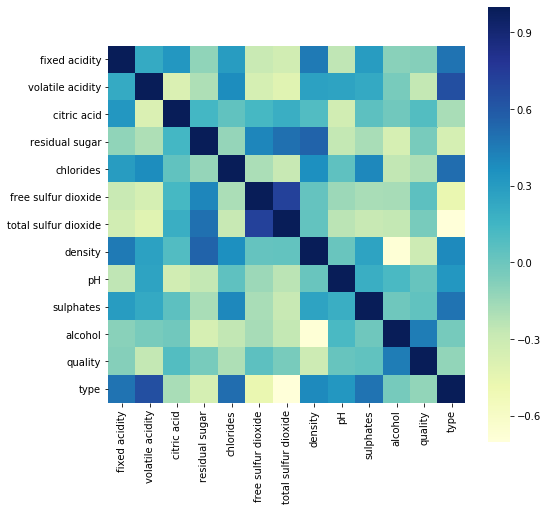

In [7]:
plt.figure(figsize=(8, 8))
sns.heatmap(wines.corr(), square=True, cmap="YlGnBu")
plt.show()

## Response und Prädiktoren
Die Qualität der Weine bildet die Zielvariable und alle anderen Variablen bilden die erklärenden Variablen.

In [8]:
X = wines.drop('quality', axis=1)
y = wines.quality

In [9]:
y = y.values

In [10]:
X = X.values

In [11]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [12]:
X.shape, y.shape

((6497, 12), (6497,))

## y_reg
In 'y_reg' werden die Qualitätsstufen numerisch gespeichert.

In [13]:
y_reg = y

## y_cat
In 'y_cat' werden die Qualitätsstufen als string gespeichert und OneHotEncoded. Es werden nur jene Ausprägungen gespeichert, die auch Beobachtungen enthalten.

In [14]:
from keras.utils import to_categorical

y_cat = to_categorical(pd.Categorical(y.astype(str)))
y_cat = pd.DataFrame(y_cat).drop(0, axis=1)
y_cat = pd.DataFrame(y_cat).drop(1, axis=1)
y_cat = pd.DataFrame(y_cat).drop(2, axis=1) 

Using TensorFlow backend.


In [15]:
pd.DataFrame(y_cat).head()

,3,4,5,6,7,8,9
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Train Test Split
X und die beiden y werden mit train test split aufgeteilt.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_cat, test_size=0.2, random_state=123)

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## EarlyStopping
Mit EarlyStopping soll ein overfitting verhindert werden. Patience 3 bedeutet, dass das Training abgebrochen wird, falls 3 Epochen die val_accuracy nicht verbessert wird.

In [18]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_monitor = EarlyStopping(patience=3)

In [19]:
in_cols = X.shape[1]
out_cols = y_cat.shape[1]

In [20]:
from keras.layers import Input

## Layer
Mit 3 hidden layern und 2 batch layern wurde versucht die eine hohe val_accuracy zu erreichen. Dazu wurde zuerst eine Regression aufgestellt, deren Ergebniss dann in eine Klassifikation hineinfließt. Trotz mehrerer Versuche reichte das Modell nicht um mindestens 50% Genauigkeit zu erreichen.

In [27]:
input_tensor = Input(shape=(in_cols,))
hidden_1 = Dense(8, activation='relu', name='hidden_1')(input_tensor)
batch_1 = BatchNormalization()(hidden_1)
hidden_2 = Dense(16, activation='relu', name='hidden_2')(batch_1)
batch_2 = BatchNormalization()(hidden_2)
hidden_3 = Dense(16, activation='relu', name='hidden_3')(batch_2)
output_tensor_reg = Dense(1, name='Regression')(hidden_3)

output_tensor_class = Dense(out_cols, activation='sigmoid', name='Classification')(output_tensor_reg)

In [28]:
from keras.models import Model

model = Model(input_tensor, [output_tensor_reg, output_tensor_class])

model.compile(loss=['mse', 'categorical_crossentropy'],
             optimizer='adam',
             metrics=['accuracy'])

## Parameter
Das Modell hat insgesamt 647 Parameter, davon sind 599 trainierbar.

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12)                0         
_________________________________________________________________
hidden_1 (Dense)             (None, 8)                 104       
_________________________________________________________________
batch_normalization_3 (Batch (None, 8)                 32        
_________________________________________________________________
hidden_2 (Dense)             (None, 16)                144       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
hidden_3 (Dense)             (None, 16)                272       
_________________________________________________________________
Regression (Dense)           (None, 1)                 17        
__________

In [30]:
model_training = model.fit(
    X_train_scaled,
    [y_reg_train, y_class_train],
    validation_data=(X_test_scaled, [y_reg_test, y_class_test]),
    batch_size=16,
    epochs=50,
    callbacks=[early_stopping_monitor],
    verbose=False)

## Accuracy
Train und Test Genauigkeit liegen mit 44% ca. gleich auf.

In [31]:
model.evaluate(X_train_scaled, [y_reg_train, y_class_train], batch_size=16)

5197/5197 [==============================] - 0s 94us/step


[1.741185304520794,
 0.4864309587133649,
 1.254754342458467,
 0.5483933038750084,
 0.4365980373980427]

In [32]:
model.evaluate(X_test_scaled, [y_reg_test, y_class_test], batch_size=16)

1300/1300 [==============================] - 0s 72us/step


[1.7685952296623817,
 0.5052680028401888,
 1.2633272193028378,
 0.5376923076923077,
 0.43615384615384617]

## Scores
Auch über 14 Epochen hinweg bleibt die Test Genauigkeit sehr stabil und verändert sich kaum.

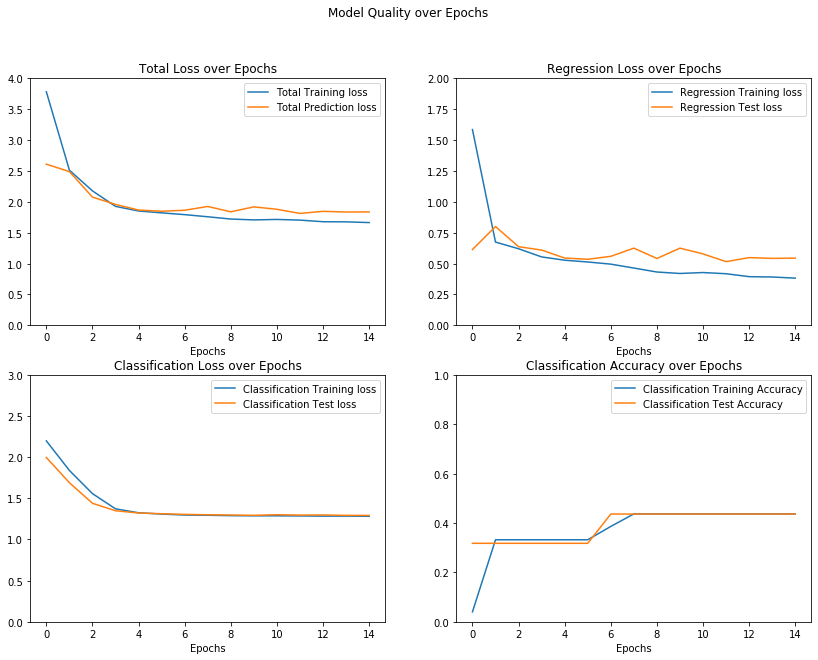

In [64]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0,0].plot(model_training.history['loss'])
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylim([0, 4])
ax[0,0].set_title('Total Loss over Epochs')
ax[0,0].plot(model_training.history['val_loss'])
ax[0,0].legend(['Total Training loss', 'Total Prediction loss'])


ax[0,1].plot(model_training.history['Regression_loss'])
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylim([0, 2])
ax[0,1].set_title('Regression Loss over Epochs')
ax[0,1].plot(model_training.history['val_Regression_loss'])
ax[0,1].legend(['Regression Training loss', 'Regression Test loss']) 


ax[1,0].plot(model_training.history['Classification_loss'])
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylim([0, 3])
ax[1,0].set_title('Classification Loss over Epochs')
ax[1,0].plot(model_training.history['val_Classification_loss'])
ax[1,0].legend(['Classification Training loss', 'Classification Test loss'])

ax[1,1].plot(model_training.history['Classification_acc'])
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylim([0, 1])
ax[1,1].set_title('Classification Accuracy over Epochs')
ax[1,1].plot(model_training.history['val_Classification_acc'])
ax[1,1].legend(['Classification Training Accuracy', 'Classification Test Accuracy'])

fig.suptitle("Model Quality over Epochs")

plt.show()